<a href="https://colab.research.google.com/github/MJ-7-Kang/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_12%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12강 정형 데이터 분석 : 서울시 공공 자전거 데이터 활용

### 목표

공공 자전거 이용 특성을 파악하고, 날씨와 자전거 이용량의 상관관계를 분석하여 데이터 기반의 정책 수립에 필요한 인사이트를 도출

### 분석 프로세스 개요

1. 데이터 수집 및 전처리
  - CSV 형태의 데이터 수집
  - 기초 통계량 산출
  - 결측치 처리 및 이상치 제거
  - 날짜/시간 데이터 형식 변환
2. 데이터 분석
  - 시계열 패턴 분석
3. 연계 분석
  - 강수량 데이터와의 연계 분석
  - 상관관계 분석
  - 정책 제언으로 연결

In [ ]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

- 런타임 -> 세션 다시 시작

In [ ]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

### 12-1 따릉이 대역 기록 2023-04 업로드 및 압축 해제

- 따릉이 데이터 다운로드
  - [서울 열린데이터 광장](https://data.seoul.go.kr)
  - 검색어 : 따릉이
  - 서울시 따릉이 대여소별 대여/반납 승객수 정보
  - 2023-04 다운로드 후 업로드

In [ ]:
!unzip tpss_bcycl_od_statnhm_202304.zip -d tpss_bcycl_od_statnhm_202304

## 12-2 CSV 형태의 데이터 수집

In [29]:
import glob
import pandas as pd

## CSV 파일 목록 가져오기
all_files = glob.glob("tpss_bcycl_od_statnhm_202304/*.csv")
dataframes = []
for filename in all_files:
    ## CSV 파일 읽어서 데이터프레임화
    df = pd.read_csv(filename, encoding='cp949')
    dataframes.append(df)
## 모든 데이터프레임 결합
df = pd.concat(dataframes, axis=0, ignore_index=True)

## 상위 5행 출력
df.head(5)

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,20230415,출발시간,0,ST-1447,전농2동_037_1,ST-1447,전농2동_037_1,1,0,0
1,20230415,출발시간,0,ST-1639,상계8동_035_1,ST-1639,상계8동_035_1,1,0,0
2,20230415,출발시간,0,ST-1661,자양4동_005_1,ST-1661,자양4동_005_1,1,0,0
3,20230415,출발시간,0,ST-243,용답동_003_1,ST-243,용답동_003_1,1,0,0
4,20230415,출발시간,0,ST-2888,우장산동_020_1,ST-2888,우장산동_020_1,1,1,0


## 12-3 기초 통계량 산출

In [31]:
## 수치형 데이터 요약 통계 출력
print('수치형 데이터 요약 통계\n', df.describe().to_markdown())
## 범주형 데이터 요약 통계 출력
print('범주형 데이터 요약 통계\n', df.describe(include=['object']).to_markdown())

수치형 데이터 요약 통계
 |       |   기준_날짜 |    기준_시간대 |    전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|------------:|---------------:|-------------:|---------------:|-----------------:|
| count | 7.76947e+06 |    7.76947e+06 |  7.76947e+06 |    7.76947e+06 |      7.76947e+06 |
| mean  | 2.02304e+07 | 1451.5         |  1.07513     |   22.9326      |   2704.27        |
| std   | 8.52204     |  561.131       |  0.309264    |   31.5494      |  11951.9         |
| min   | 2.02304e+07 |    0           |  1           |    0           |      0           |
| 25%   | 2.02304e+07 | 1020           |  1           |    6           |    854           |
| 50%   | 2.02304e+07 | 1600           |  1           |   12           |   1551           |
| 75%   | 2.02304e+07 | 1855           |  1           |   27           |   2990           |
| max   | 2.02304e+07 | 2355           | 17           | 2001           |      1.29444e+07 |
범주형 데이터 요약 통계
 |        | 집계_기준   | 시작_대여소_ID   | 시작_대여소명   | 종료_대여소_ID   | 종료_대여소명   |
|

## 12-4 결측치 및 이상치 제거

In [32]:
## 결측치 제거
df = df.dropna()

## '전체_이용_분' 컬럼 값 필터링 (1분 이하, 180분 이상 제거)
df = df[(df['전체_이용_분']>1)& ((df['전체_이용_분']<180))]
## '전체_이용_거리' 컬럼 값 필터링 (10M 이하, 10000M 이상 제거)
df = df[(df['전체_이용_거리']>10)&((df['전체_이용_분']<1000))]
## '집계_기준' 컬럼 필터링 (출발시간만 사용)
df = df[df['집계_기준']== '출발시간']

## 수치형 데이터 요약 통계 출력
print('수치형 데이터 요약 통계\n', df.describe().to_markdown())
## 범주형 데이터 요약 통계 출력
print('범주형 데이터 요약 통계\n', df.describe(include=['object']).to_markdown())

수치형 데이터 요약 통계
 |       |   기준_날짜 |    기준_시간대 |    전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|------------:|---------------:|-------------:|---------------:|-----------------:|
| count | 3.66076e+06 |    3.66076e+06 |  3.66076e+06 |    3.66076e+06 |      3.66076e+06 |
| mean  | 2.02304e+07 | 1435.93        |  1.06737     |   22.6928      |   2761.14        |
| std   | 8.52052     |  558.537       |  0.281395    |   25.9455      |  12168.6         |
| min   | 2.02304e+07 |    0           |  1           |    2           |     11           |
| 25%   | 2.02304e+07 | 1010           |  1           |    7           |    952           |
| 50%   | 2.02304e+07 | 1550           |  1           |   13           |   1650           |
| 75%   | 2.02304e+07 | 1845           |  1           |   28           |   3109           |
| max   | 2.02304e+07 | 2355           | 14           |  179           |      1.29444e+07 |
범주형 데이터 요약 통계
 |        | 집계_기준   | 시작_대여소_ID   | 시작_대여소명   | 종료_대여소_ID   | 종료_대여소명   |
|

## 12-5 날짜/시간 데이터 형식 변환

<Axes: xlabel='요일'>

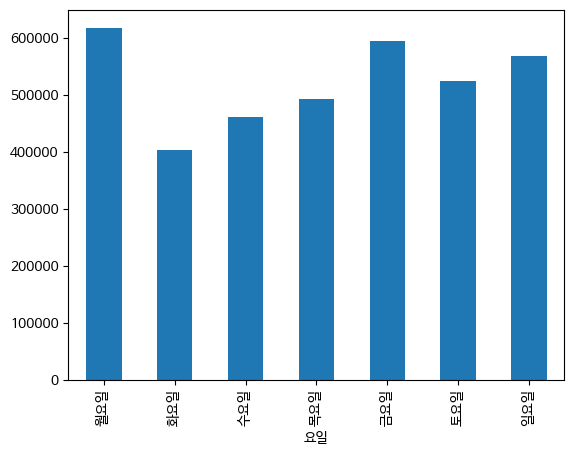

In [44]:
## '기준_날짜' 컬럼 datetime 형식으로 변환 (%Y%m%d)
df['기준_날짜'] = pd.to_datetime(df['기준_날짜'], format='%Y%m%d')
##
## '요일' 컬럼 생성
day_mapping = {
    'Monday': '월요일',
    'Tuesday': '화요일',
    'Wednesday': '수요일',
    'Thursday': '목요일',
    'Friday': '금요일',
    'Saturday': '토요일',
    'Sunday': '일요일'
}

# 한글 요일을 원하면 매핑하거나 format 옵션을 사용할 수 있습니다.
df['요일'] = df['기준_날짜'].dt.day_name().map(day_mapping)

day_df = df['요일'].value_counts().reindex(day_mapping.values())
print('요일별 이용량', day_df)
day_df.plot(kind='bar')


## 전처리 결과 확인

In [ ]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계:\n", df.describe().to_markdown())
## 범주형 데이터 요약 통계 출력
print("\n범주형 데이터 요약 통계:\n", df.describe(include=['object']).to_markdown())

# 2. 데이터 분석

## 12-6 요일별 이용량 분석

In [ ]:
import matplotlib.pyplot as plt

## 요일별 이용량 계산 및 정렬
day_df = df['요일'].value_counts().reindex(day_mapping.values())

## 요일별 이용량 출력
print("요일별 이용량:\n", day_df)

## 12-7 요일별 이용량 시각화

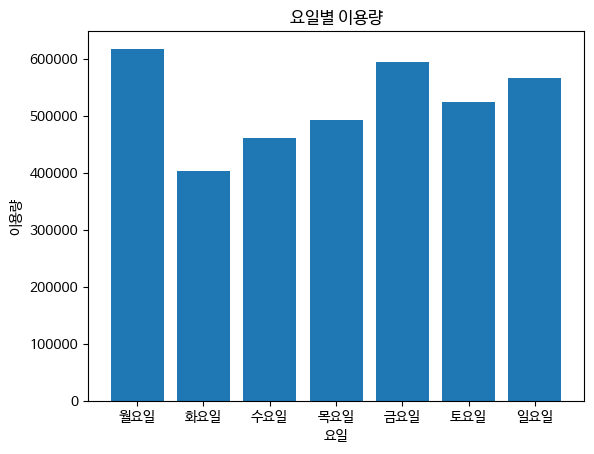

In [46]:
import matplotlib.pyplot as plt

## 요일별 이용량 막대 그래프 생성
plt.bar(day_df.index, day_df.values)

plt.title('요일별 이용량')
plt.xlabel('요일')
plt.ylabel('이용량')
plt.show()

In [ ]:
## Dataframe의 plot을 이용한 요일별 이용량 막대 그래프 생성
day_df.plot(kind='bar')
plt.show()

## 12-8 시간별 이용량 분석 및 시각화

시간별 이용량:
 출발_시
0      79363
1      55141
2      35258
3      23057
4      17821
5      30083
6      66238
7     169745
8     257045
9     154815
10    122488
11    142747
12    161259
13    167252
14    177914
15    203105
16    250957
17    320037
18    382065
19    244300
20    194999
21    179549
22    150870
23     74655
Name: count, dtype: int64


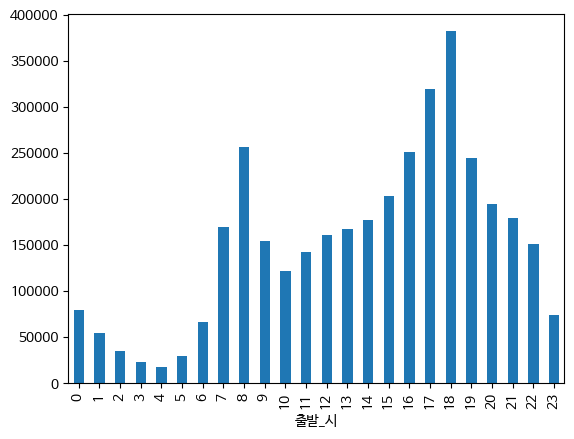

In [47]:
## '출발_시' 컬럼 생성 (기준_시간대 // 100)
df['출발_시']=df['기준_시간대']//100

## 시간별 이용량 계산 및 정렬 (hour_df로 저장)
hour_df=df['출발_시'].value_counts().sort_index()

## 시간별 이용량 출력
print("시간별 이용량:\n", hour_df)

## 시간별 이용량 막대 그래프 생성
hour_df.plot(kind='bar')
plt.show()

## 12-9 일자별 이용량 분석 및 시각화

일자별 이용량:
 기준_날짜
2023-04-01    141494
2023-04-02    139970
2023-04-03    163281
2023-04-04    126521
2023-04-05     21609
2023-04-06     57816
2023-04-07    128923
2023-04-08    114632
2023-04-09    111809
2023-04-10    149655
2023-04-11     97342
2023-04-12    132391
2023-04-13    136953
2023-04-14    152778
2023-04-15     86049
2023-04-16     98054
2023-04-17    147918
2023-04-18     98270
2023-04-19    165226
2023-04-20    138902
2023-04-21    161595
2023-04-22    136275
2023-04-23    120464
2023-04-24    156950
2023-04-25     81083
2023-04-26    141477
2023-04-27    159419
2023-04-28    151642
2023-04-29     45320
2023-04-30     96945
Name: count, dtype: int64


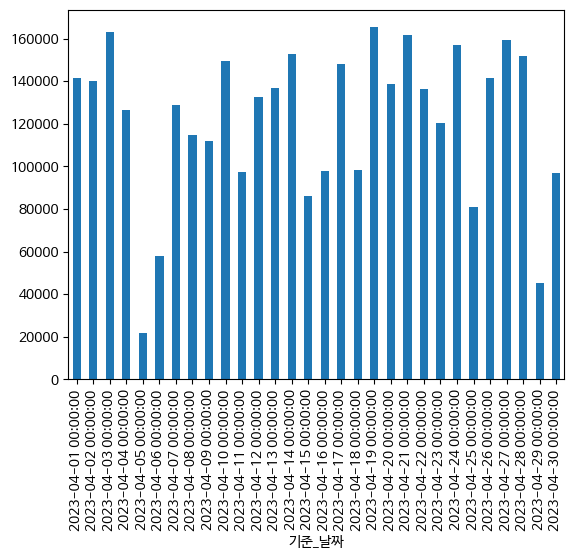

In [48]:
## 일자별 이용량 계산 및 정렬
daily_usage_df = df['기준_날짜'].value_counts().sort_index()
## 일자별 이용량 출력
print("일자별 이용량:\n", daily_usage_df)

## 일자별 이용량 막대 그래프 생성
daily_usage_df.plot(kind='bar')
plt.show()

# 3. 연계 분석

- 기상청 기상자료개방포탈 자료 수집
  - 기후통계분석 > 통계분석 > 조건별통계
  - https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do?pgmNo=179
  - 지역/지점 : 서울
  - 요소 : 강수량
  - 기간 : 일, 2023년 ~ 2023년
  - 조건 : 04월, 01 ~ 31일
- 다운로드 후 파일명 `seoul_rain_2023_04.csv`로 변경하여 colab에 업로드

## 12-10 강수량 데이터 로드

In [ ]:
## 강수량 데이터 CSV 파일 로드
file_path = 'seoul_rain_2023_04.csv'
rain_df = pd.read_csv(file_path, encoding='cp949', skiprows=12)
rain_df.head(5)

## 12-11 강수량 데이터 전처리

In [ ]:
## '일시' 컬럼 datetime 형식으로 변환
rain_df['일시'] = pd.to_datetime(rain_df['일시'], format='%Y-%m-%d')
## '강수량(mm)' 컬럼 결측치 0으로 채우기

## 불필요한 컬럼 제거
rain_df.drop(columns=['\t지점번호', 'Unnamed: 6'], inplace=True)

## 12-12 일자별 이용량 데이터와 강수량 데이터 병합

In [ ]:
## 일자별 이용량과 강수량 데이터 병합 (daily_usage_gf의 기준_날짜, rain_df의 일시를 기준으로 결합)

## 'count' 컬럼명 '이용량'으로 변경
merged_df.rename(columns={'count': '이용량'}, inplace=True)
## 병합된 데이터프레임 상위 5행 출력
merged_df.head(5)

## 12-13 이용량 및 강수량 시각화

In [ ]:
## 두 개의 y축을 가진 서브플롯 생성
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() ## 두 번째 y축 생성

## 첫 번째 y축에 이용량 막대 그래프 그리기

## 두 번째 y축에 강수량 꺾은선 그래프 그리기


## x축 및 y축 레이블 설정
ax1.set_xlabel('날짜')
ax1.set_ylabel('이용량', color='b')
ax2.set_ylabel('강수량(mm)', color='r')

## 그래프 표시
plt.show()

## 12-14 강수량과 이용량 상관관계 분석

In [ ]:
import seaborn as sns ## seaborn 라이브러리 임포트

## 강수량이 있는 날만 필터링
merged_onlyrain_df = merged_df[merged_df['강수량(mm)'] > 0]
## 강수량과 이용량의 상관계수 계산
corr = merged_onlyrain_df['이용량'].corr(merged_onlyrain_df['강수량(mm)'])
## 상관계수 출력
print("강수량과 이용량의 상관계수:", corr)

## 강수량과 이용량의 회귀선 그래프 생성


## y축 범위 설정
plt.ylim(0, merged_onlyrain_df['이용량'].max()*1.1)

## 그래프 제목 및 축 레이블 설정
plt.title(f'강수량과 이용량 상관관계 (r = {corr:.2f})')
plt.xlabel('강수량 (mm)')
plt.ylabel('이용 건수')
## 그래프 표시
plt.show()

## 12-15 OLS 회귀 모델 생성 및 분석 및 귀무가설 검증

In [ ]:
import statsmodels.formula.api as smf ## statsmodels.formula.api 임포트

## 컬럼명 변경: '강수량(mm)' -> '강수량_mm' (formula API 호환을 위해)
merged_onlyrain_df = merged_onlyrain_df.copy()
merged_onlyrain_df.rename(columns={'강수량(mm)': '강수량_mm'}, inplace=True)

## OLS 모델 정의 및 학습

results = model.fit()

## 모델 요약 결과 출력
print(results.summary())

## 귀무가설 검증 해석
## 강수량_mm 계수에 대한 p-value를 확인하여 귀무가설 (강수량이 이용량에 미치는 영향이 0이다) 검증
## 일반적으로 p-value가 0.05 미만이면 귀무가설을 기각하고 유의미한 영향이 있다고 해석
print("\n--- 귀무가설 검증 (강수량 계수) ---")
p_value = results.pvalues['강수량_mm']
print(f"강수량_mm 계수의 p-value: {p_value:.4f}")
if p_value < 0.05:
    print("p-value가 0.05보다 작으므로 귀무가설을 기각합니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미칩니다.")
else:
    print("p-value가 0.05보다 크므로 귀무가설을 기각할 수 없습니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미치지 않는다고 볼 수 있습니다.")